notes:
1. metrics in mlflow
2. gender remove other
3. AUC metrics theory
4. codes in cells
5. math sources for calculating feature engineering
6. optuna for hyper tuninig instead of random search

In [1]:
%pip install mlflow

  Using cached pyyaml-6.0.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.4 kB)
  Using cached cffi-2.0.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.6 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached typing_inspection-0.4.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached anyio-4.11.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached pycparser-2.23-py3-none-any.whl.metadata (993 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 771.8 kB/s  0:00:11m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━

In [32]:
!pip install sqlalchemy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate, 
    RandomizedSearchCV, cross_val_score, cross_val_predict
)
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, precision_recall_curve, roc_curve, auc
)
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [34]:
df = pd.read_csv('combined_credit_data.csv')
df.head()

,client_id,full_name,age,gender,marital_status,region,education_level,employment_years,risk_score,risk_level,approve_credit,income,credit_score,loan_amount,past_due,monthly_expenses,savings_balance
0,1,Client_1,59,male,single,Andijan,high_school,8,39.063,0,1,6751.41,773,7313.60,1,3968.91,3906.33
1,2,Client_2,49,male,widowed,Andijan,high_school,27,111.792,2,1,6667.90,628,13648.15,2,2094.24,11396.77
2,3,Client_3,35,male,widowed,Samarkand,high_school,22,48.099,0,1,7551.83,756,8053.81,1,1922.36,14182.23
3,4,Client_4,63,male,single,Andijan,high_school,21,72.197,1,1,6345.03,706,12914.76,4,3195.50,3431.10
4,5,Client_5,28,female,married,Tashkent,high_school,23,168.171,3,0,7265.29,515,18429.49,3,4154.77,15894.40


In [ ]:

class CreditScoringModel:
    def __init__(self, data_path):
        """Initialize the CreditScoringModel with data path."""
        self.data_path = data_path
        self.data = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.preprocessor = None
        self.target_columns = ['risk_score', 'risk_level', 'approve_credit']
        self.class_distribution = None
        self.feature_importances_ = None
        
    def load_data(self):
        """Load and prepare the dataset."""
        print("Loading data...")
        self.data = pd.read_csv(self.data_path)
        print(f"Dataset shape: {self.data.shape}")
        return self.data
    
    def preprocess_data(self, target_column='approve_credit'):
        """Preprocess the data for modeling."""
        if target_column not in self.target_columns:
            raise ValueError(f"Target column must be one of {self.target_columns}")
            
        print(f"\nPreprocessing data with target: {target_column}")
        
        # Define columns to drop
        drop_columns = ['client_id', 'full_name']
        
        # Remove target column and other leakage targets from features
        # These are all potential targets or highly correlated with the target
        leakage_targets = ['risk_score', 'risk_level', 'credit_score', target_column]
        
        # Drop unnecessary columns and leakage targets
        self.data = self.data.drop(columns=[col for col in drop_columns if col in self.data.columns])
        
        # Define features and target, ensuring no data leakage
        X = self.data.drop(columns=leakage_targets, errors='ignore')
        
        # Print remaining features for verification
        print("\nSelected features:", X.columns.tolist())
        print("Dropped features due to potential leakage:", leakage_targets)
        y = self.data[target_column]
        
        # Convert target to binary if needed
        if y.dtype == 'object':
            y = y.map({'N': 0, 'Y': 1})  # Assuming 'N'/'Y' for approve_credit
        
        # Split data into train and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Get numerical and categorical features
        numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
        
        # Create preprocessing pipelines
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        
        # Combine preprocessing steps
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ],
            remainder='drop'  # Drop other columns not specified
        )
        
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def feature_engineering(self):
        """Create new features with proper handling of missing values and log transforms."""
        print("\nPerforming feature engineering...")
        
        def safe_divide(x, y, default=np.nan):
            """Safely divide two arrays, returning default where division is not possible."""
            with np.errstate(divide='ignore', invalid='ignore'):
                result = np.where(y != 0, x / y, default)
                return np.where(np.isfinite(result), result, default)
        
        def engineer_features(df):
            df = df.copy()
            
            # 1. Financial Health Metrics
            if all(col in df.columns for col in ['income', 'monthly_expenses']):
                # Disposable income after expenses
                df['disposable_income'] = df['income'] - (df['monthly_expenses'] * 12)
                
                # Savings rate
                df['savings_rate'] = safe_divide(
                    df['savings_balance'], 
                    df['income'], 
                    default=0
                )
                
                # Debt-to-income ratio (if loan_amount represents debt)
                if 'loan_amount' in df.columns:
                    df['debt_to_income'] = safe_divide(
                        df['loan_amount'], 
                        df['income'], 
                        default=0
                    )
            
            # 2. Employment Stability
            if 'employment_years' in df.columns:
                # Categorize employment stability
                bins = [-1, 1, 5, 10, np.inf]
                labels = ['<1', '1-5', '5-10', '10+']
                df['employment_stability'] = pd.cut(
                    df['employment_years'], 
                    bins=bins, 
                    labels=labels
                )
                
                # Binary stability indicator
                df['is_employed_stable'] = (df['employment_years'] >= 2).astype(int)
            
            # 3. Age-related Features
            if 'age' in df.columns:
                # Age groups
                age_bins = [18, 25, 35, 50, 65, np.inf]
                age_labels = ['18-24', '25-34', '35-49', '50-64', '65+']
                df['age_group'] = pd.cut(
                    df['age'], 
                    bins=age_bins, 
                    labels=age_labels
                )
                
                # Interaction: Age and Employment
                if 'employment_years' in df.columns:
                    df['years_employed_per_age'] = safe_divide(
                        df['employment_years'],
                        df['age'] - 18,  # Assuming work starts at 18
                        default=0
                    )
            
            # 4. Credit History Features
            if 'past_due' in df.columns:
                # Past due categories
                df['past_due_category'] = pd.cut(
                    df['past_due'],
                    bins=[-1, 0, 1, 3, 6, np.inf],
                    labels=['0', '1', '2-3', '4-6', '6+'],
                    right=False
                )
                
                # Binary indicator for any past due
                df['has_past_due'] = (df['past_due'] > 0).astype(int)
            
            # 5. Log Transforms for Right-Skewed Features
            for col in ['income', 'loan_amount', 'savings_balance', 'monthly_expenses']:
                if col in df.columns and df[col].min() >= 0:
                    df[f'log1p_{col}'] = np.log1p(df[col])
            
            # 6. Interaction Features
            if all(col in df.columns for col in ['income', 'savings_balance']):
                df['savings_to_income'] = safe_divide(
                    df['savings_balance'],
                    df['income'],
                    default=0
                )
            
            if all(col in df.columns for col in ['loan_amount', 'income']):
                df['loan_to_income'] = safe_divide(
                    df['loan_amount'],
                    df['income'],
                    default=0
                )
            
            # 7. Binning Continuous Variables
            if 'monthly_expenses' in df.columns and 'income' in df.columns:
                expense_ratio = safe_divide(
                    df['monthly_expenses'] * 12,  # Annualize
                    df['income'],
                    default=0
                )
                df['expense_ratio_category'] = pd.cut(
                    expense_ratio,
                    bins=[-0.01, 0.3, 0.5, 0.7, 1.0, np.inf],
                    labels=['<30%', '30-50%', '50-70%', '70-100%', '>100%']
                )
            
            # 8. Missing Value Indicators
            numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
            for col in numeric_cols:
                if df[col].isnull().any():
                    df[f'{col}_missing'] = df[col].isnull().astype(int)
            
            # 9. Handle remaining missing values
            for col in df.select_dtypes(include=['number']).columns:
                if df[col].isnull().any():
                    df[col].fillna(df[col].median(), inplace=True)
            
            # 10. Convert categorical variables to string type to avoid issues with OneHotEncoder
            for col in df.select_dtypes(include=['category']).columns:
                df[col] = df[col].astype(str)
            
            return df
        
        # Apply feature engineering to both train and test sets
        self.X_train = engineer_features(self.X_train)
        self.X_test = engineer_features(self.X_test)
        
        return self.X_train, self.X_test
    
    def train_model(self, tune_hyperparams=False, cv_folds=5):
        """Train the XGBoost model with cross-validation and optional hyperparameter tuning."""
        print(f"Training XGBoost model with {cv_folds}-fold cross-validation...")
        
        # Calculate scale_pos_weight for imbalanced classes
        # XGBoost's scale_pos_weight = number of negative examples / number of positive examples
        # We want to upweight the minority class (rejections = 0)
        n_pos = (self.y_train == 1).sum()  # Majority class (approvals)
        n_neg = (self.y_train == 0).sum()  # Minority class (rejections)
        
        # Since 0 is the minority class, we should use n_pos / n_neg
        # This will make the model pay more attention to the minority class (rejections)
        scale_pos_weight = n_pos / max(n_neg, 1)  # Avoid division by zero
        
        # Store class distribution info
        self.class_distribution = {
            'positive': n_pos,
            'negative': n_neg,
            'total': len(self.y_train),
            'positive_ratio': n_pos / len(self.y_train),
            'negative_ratio': n_neg / len(self.y_train),
            'imbalance_ratio': n_neg / n_pos if n_pos > 0 else float('inf')
        }
        
        print(f"Class distribution: {n_neg} negative (rejections), {n_pos} positive (approvals)")
        print(f"Imbalance ratio (negative/positive): {(n_neg/n_pos):.2f} to 1")
        print(f"Using scale_pos_weight = {scale_pos_weight:.2f} to upweight minority class (rejections)")
        
        print(f"Class distribution: {n_neg} negative, {n_pos} positive (ratio: {scale_pos_weight:.2f} to 1)")
        
        # Define base XGBoost parameters with class weights
        xgb_params = {
            'n_estimators': 500,
            'max_depth': 5,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'use_label_encoder': False,
            'scale_pos_weight': scale_pos_weight,  # Handle class imbalance
            'min_child_weight': 3,
            'gamma': 0.2,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
            'eval_metric': ['logloss', 'auc', 'error', 'aucpr'],  # Added aucpr for imbalanced data
            'tree_method': 'hist',
            'n_jobs': -1,
            'objective': 'binary:logistic',  # Explicitly set binary classification
            'enable_categorical': True  # Enable categorical features
        }
        
        # Create base pipeline without the classifier
        base_pipeline = Pipeline([
            ('preprocessor', self.preprocessor)
        ])
        
        # Preprocess the data once
        X_train_processed = base_pipeline.fit_transform(self.X_train)
        
        # Get feature names after preprocessing
        numeric_features = self.X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_features = self.X_train.select_dtypes(include=['object', 'category']).columns.tolist()
        
        # Get one-hot encoded feature names if there are categorical features
        if categorical_features:
            try:
                ohe = self.preprocessor.named_transformers_['cat'].named_steps['onehot']
                categorical_names = ohe.get_feature_names_out(categorical_features)
                feature_names = numeric_features + list(categorical_names)
            except Exception as e:
                print(f"Could not get feature names: {e}")
                feature_names = None
        else:
            feature_names = numeric_features
        
        if tune_hyperparams:
            print("Performing hyperparameter tuning with RandomizedSearchCV...")
            
            # Define parameter grid
            param_grid = {
                'n_estimators': [200, 300, 400, 500],
                'max_depth': [3, 4, 5, 6],
                'learning_rate': [0.01, 0.05, 0.1],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'min_child_weight': [1, 3, 5],
                'gamma': [0, 0.1, 0.2, 0.3],
                'reg_alpha': [0, 0.1, 1.0],
                'reg_lambda': [0.1, 1.0, 10.0]
            }
            
            # Create base model
            xgb = XGBClassifier(**xgb_params)
            
            # Perform random search with cross-validation  -> optuna
            random_search = RandomizedSearchCV(
                estimator=xgb,
                param_distributions=param_grid,
                n_iter=30,
                scoring='roc_auc',
                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                verbose=2,
                random_state=42,
                n_jobs=-1,
                refit=True
            )
            
            # Fit the random search
            random_search.fit(X_train_processed, self.y_train)
            
            # Get best parameters and update model
            print(f"Best parameters: {random_search.best_params_}")
            print(f"Best CV score: {random_search.best_score_:.4f}")
            
            # Use the best model
            best_xgb = random_search.best_estimator_
            
            # Create final pipeline with best model
            self.model = Pipeline([
                ('preprocessor', self.preprocessor),
                ('classifier', best_xgb)
            ])
            
            # Fit on full training data
            self.model.fit(self.X_train, self.y_train)
            
        else:
            # Cross-validate the base model
            print("Performing cross-validation...")
            scoring = {
                'auc': 'roc_auc',
                'f1': 'f1',
                'precision': 'precision',
                'recall': 'recall',
                'accuracy': 'accuracy',
                'average_precision': 'average_precision'
            }
            
            # Create base model without early stopping for cross-validation
            xgb = XGBClassifier(**xgb_params)
            
            # Create pipeline for cross-validation
            cv_pipeline = Pipeline([
                ('preprocessor', self.preprocessor),
                ('classifier', xgb)
            ])
            
            # Perform cross-validation without early stopping
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
            cv_results = cross_validate(
                cv_pipeline,
                self.X_train,
                self.y_train,
                cv=cv,
                scoring=scoring,
                return_train_score=True,
                n_jobs=-1,
                error_score='raise'  # Raise error if any fold fails
            )
            
            # Print CV results
            print("\nCross-validation results:")
            for metric in scoring.keys():
                test_scores = cv_results[f'test_{metric}']
                print(f"{metric.upper()}: {np.mean(test_scores):.4f} (+/- {np.std(test_scores):.4f})")
            
            # Train final model on full training data with early stopping
            print("\nTraining final model on full training set with early stopping...")
            
            # Split training data for early stopping (use 80-20 split)
            X_train_split, X_val, y_train_split, y_val = train_test_split(
                self.X_train, 
                self.y_train, 
                test_size=0.2, 
                random_state=42,
                stratify=self.y_train
            )
            
            # Create final model with early stopping parameters
            final_xgb_params = xgb_params.copy()
            final_xgb_params.update({
                'early_stopping_rounds': 50,
                'eval_metric': ['logloss', 'aucpr']  # Focus on these metrics for early stopping
            })
            
            final_xgb = XGBClassifier(**final_xgb_params)
            
            # Preprocess the data
            X_train_processed = self.preprocessor.fit_transform(X_train_split)
            X_val_processed = self.preprocessor.transform(X_val)
            
            print("Training with early stopping on validation set...")
            # Fit with early stopping
            final_xgb.fit(
                X_train_processed, 
                y_train_split,
                eval_set=[(X_val_processed, y_val)],
                verbose=10
            )
            
            # Get the best iteration
            best_iteration = final_xgb.best_iteration
            print(f"Early stopping: Best iteration = {best_iteration}")
            
            # Create final pipeline with the best model
            self.model = Pipeline([
                ('preprocessor', self.preprocessor),
                ('classifier', XGBClassifier(**{
                    **xgb_params,
                    'n_estimators': best_iteration if best_iteration is not None else 100
                }))
            ])
            
            # Fit on full training data with optimal number of trees
            print("Fitting final model on full training data...")
            self.model.fit(self.X_train, self.y_train)
        
        # Calibrate the model for better probability estimates
        print("Calibrating model probabilities...")
        self.model = CalibratedClassifierCV(
            self.model,
            method='isotonic',
            cv='prefit'  # Use the already trained model
        )
        self.model.fit(self.X_train, self.y_train)
        
        # Extract feature importances
        self._extract_feature_importances()
        
        return self.model
    
    def _extract_feature_importances(self):
        """Extract and store feature importances from the trained model."""
        try:
            # Get the classifier from the pipeline
            if hasattr(self.model, 'calibrated_classifiers_'):
                # If using CalibratedClassifierCV
                classifier = self.model.calibrated_classifiers_[0].estimator
            else:
                classifier = self.model.named_steps['classifier']
            
            # Get feature importances
            if hasattr(classifier, 'feature_importances_'):
                importances = classifier.feature_importances_
                
                # Get feature names after preprocessing
                numeric_features = self.X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
                categorical_features = self.X_train.select_dtypes(include=['object', 'category']).columns.tolist()
                
                # Get one-hot encoded feature names
                if hasattr(self.preprocessor.named_transformers_['cat'].named_steps['onehot'], 'get_feature_names_out'):
                    categorical_names = self.preprocessor.named_transformers_['cat']\
                        .named_steps['onehot'].get_feature_names_out(categorical_features)
                else:
                    categorical_names = []
                    
                # Combine all feature names
                feature_names = numeric_features + categorical_names.tolist()
                
                # Store feature importances
                self.feature_importances_ = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importances
                }).sort_values('importance', ascending=False)
                
        except Exception as e:
            print(f"Could not extract feature importances: {str(e)}")
    
    def plot_feature_importance(self, top_n=20):
        """Plot the top N most important features."""
        if self.feature_importances_ is None:
            self._extract_feature_importances()
        
        if self.feature_importances_ is not None:
            plt.figure(figsize=(10, 8))
            sns.barplot(
                x='importance',
                y='feature',
                data=self.feature_importances_.head(top_n),
                palette='viridis'
            )
            plt.title(f'Top {top_n} Most Important Features')
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()
    
    def plot_confusion_matrix(self, y_true, y_pred, threshold):
        """Plot a confusion matrix with proper labels and formatting."""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Rejected', 'Approved'],
                   yticklabels=['Rejected', 'Approved'])
        plt.title(f'Confusion Matrix (Threshold = {threshold:.2f})')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    def plot_roc_curve(self, y_true, y_pred_proba):
        """Plot ROC curve with AUC score."""
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    
    def plot_precision_recall_curve(self, y_true, y_pred_proba):
        """Plot precision-recall curve with average precision score."""
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        avg_precision = average_precision_score(y_true, y_pred_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, lw=2, color='navy',
                label=f'Precision-Recall (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
    
    def find_optimal_threshold(self, y_true, y_pred_proba, method='f1'):
        """Find the optimal threshold based on different criteria.
        
        Args:
            y_true: True labels
            y_pred_proba: Predicted probabilities
            method: Method to find threshold ('f1', 'precision_recall', 'youden')
            
        Returns:
            float: Optimal threshold
        """
        if method == 'f1':
            # Find threshold that maximizes F1 score
            precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
            optimal_idx = np.argmax(f1_scores)
            return thresholds[optimal_idx]
        
        elif method == 'precision_recall':
            # Find threshold that maximizes the f1 score from precision-recall curve
            precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
            optimal_idx = np.argmax(f1_scores)
            return thresholds[optimal_idx]
        
        elif method == 'youden':
            # Find threshold that maximizes Youden's J statistic (sensitivity + specificity - 1)
            fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
            youden_j = tpr - fpr
            optimal_idx = np.argmax(youden_j)
            return thresholds[optimal_idx]
        
        else:
            return 0.5  # Default threshold
    
    def evaluate_model(self, threshold_method='f1'):
        """Evaluate the model on test data with optimal threshold selection."""
        if self.model is None:
            raise ValueError("Model has not been trained yet.")
            
        # Get predicted probabilities
        y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
        
        # Find optimal threshold
        threshold = self.find_optimal_threshold(self.y_test, y_pred_proba, method=threshold_method)
        
        # Make predictions using the threshold
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'roc_auc': roc_auc_score(self.y_test, y_pred_proba),
            'average_precision': average_precision_score(self.y_test, y_pred_proba),
            'precision': precision_score(self.y_test, y_pred, zero_division=0),
            'recall': recall_score(self.y_test, y_pred, zero_division=0),
            'f1_score': f1_score(self.y_test, y_pred, zero_division=0),
            'threshold': threshold
        }
        
        # Print metrics
        print("\nModel Performance Metrics:")
        print(f"- Accuracy: {metrics['accuracy']:.4f}")
        print(f"- ROC AUC: {metrics['roc_auc']:.4f}")
        print(f"- Average Precision: {metrics['average_precision']:.4f}")
        print(f"- Precision: {metrics['precision']:.4f}")
        print(f"- Recall: {metrics['recall']:.4f}")
        print(f"- F1 Score: {metrics['f1_score']:.4f}")
        print(f"- Decision Threshold: {metrics['threshold']:.4f}")
        
        # Plot confusion matrix
        self.plot_confusion_matrix(self.y_test, y_pred, threshold)
        
        # Plot ROC curve
        self.plot_roc_curve(self.y_test, y_pred_proba)
        
        # Plot precision-recall curve
        self.plot_precision_recall_curve(self.y_test, y_pred_proba)
        
        # Plot feature importance
        self.plot_feature_importance()
        
        return metrics
    
    def save_model(self, filepath='credit_scoring_model.joblib'):
        """Save the trained model to disk."""
        if self.model is None:
            raise ValueError("No trained model to save.")
            
        joblib.dump({
            'model': self.model,
            'preprocessor': self.preprocessor,
            'feature_importances': self.feature_importances_,
            'class_distribution': self.class_distribution
        }, filepath)
        print(f"Model saved to {filepath}")
    
    @classmethod
    def load_model(cls, filepath):
        """Load a trained model from disk."""
        model_data = joblib.load(filepath)
        
        # Create a new instance
        instance = cls.__new__(cls)
        
        # Set attributes from saved model
        instance.model = model_data['model']
        instance.preprocessor = model_data['preprocessor']
        instance.feature_importances_ = model_data['feature_importances']
        instance.class_distribution = model_data['class_distribution']
        
        return instance


def main():
    # Initialize the model
    model = CreditScoringModel('combined_credit_data.csv')
    
    # Load and preprocess data
    data = model.load_data()
    
    # Print basic info
    print("\nDataset Info:")
    print(data.info())
    
    # Basic statistics
    print("\nBasic Statistics:")
    print(data.describe())
    
    # Check for missing values
    print("\nMissing Values:")
    print(data.isnull().sum())
    
    # Preprocess data with 'approve_credit' as target
    print("\nPreprocessing data...")
    model.preprocess_data(target_column='approve_credit')
    
    # Perform feature engineering
    print("\nPerforming feature engineering...")
    model.feature_engineering()
    
    # Train the model (set tune_hyperparams=True for hyperparameter tuning)
    print("\nTraining model...")
    model.train_model(tune_hyperparams=False)
    
    # Evaluate the model
    print("\nEvaluating model...")
    metrics = model.evaluate_model(threshold_method='f1')
    
    # Save the trained model
    model.save_model('credit_scoring_model.joblib')
    
    print("\nCredit scoring model training completed successfully!")


Loading data...
Dataset shape: (2000, 17)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         2000 non-null   int64  
 1   full_name         2000 non-null   object 
 2   age               2000 non-null   int64  
 3   gender            2000 non-null   object 
 4   marital_status    2000 non-null   object 
 5   region            2000 non-null   object 
 6   education_level   2000 non-null   object 
 7   employment_years  2000 non-null   int64  
 8   risk_score        2000 non-null   float64
 9   risk_level        2000 non-null   int64  
 10  approve_credit    2000 non-null   int64  
 11  income            2000 non-null   float64
 12  credit_score      2000 non-null   int64  
 13  loan_amount       2000 non-null   float64
 14  past_due          2000 non-null   int64  
 15  monthly_expenses  2000 non-null 

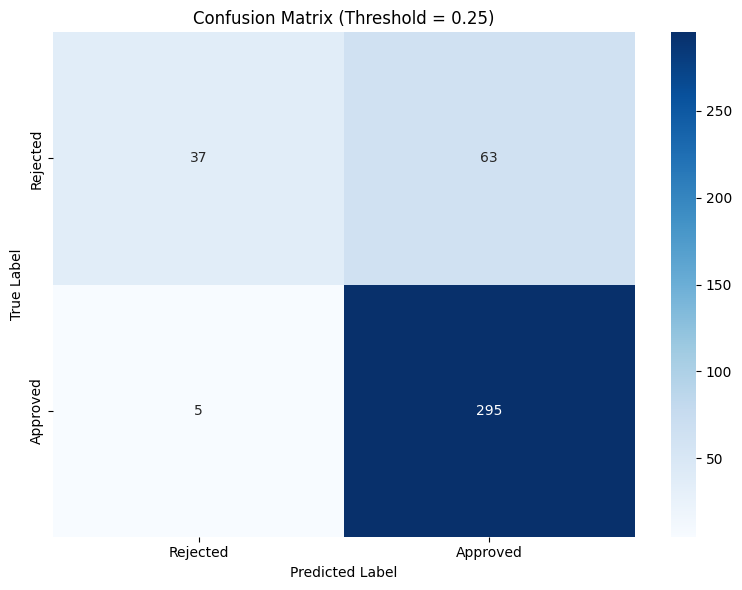

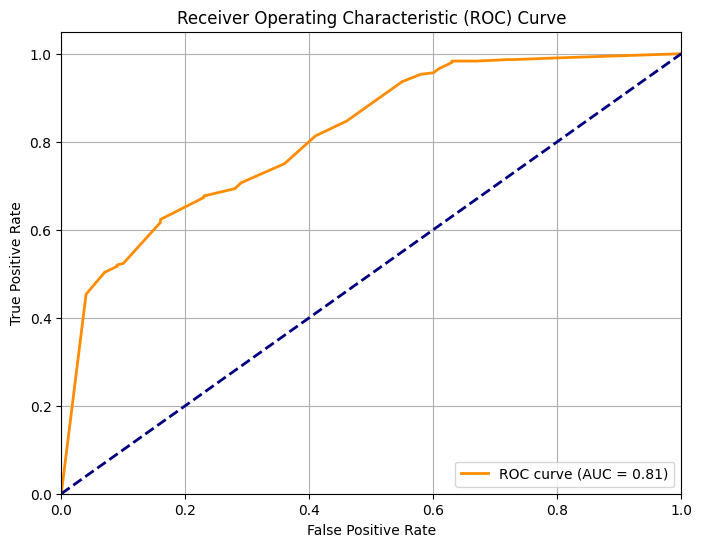

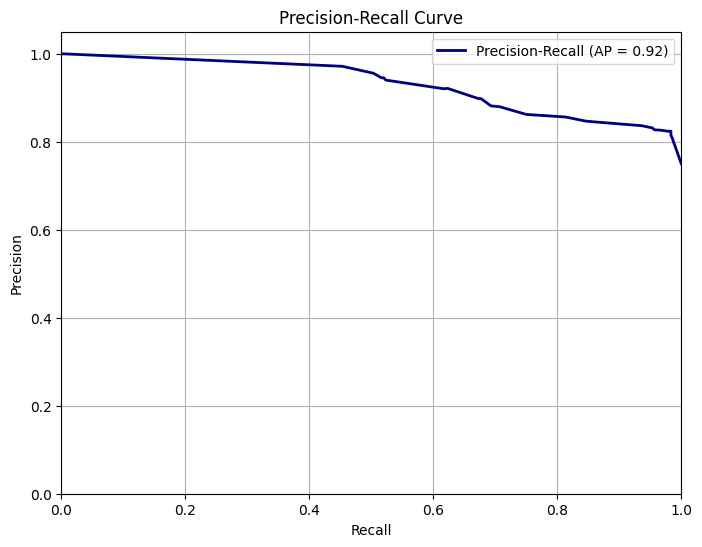

Model saved to credit_scoring_model.joblib

Credit scoring model training completed successfully!


In [55]:

main()